<a href="https://colab.research.google.com/github/lizhieffe/canonical_llm_impl/blob/main/LLM_from_scratch_chap_06_FT_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial for "LLM from Scratch" Chapter 05

https://drive.google.com/drive/u/1/folders/1a9jbhCJr_dddOT-m-4G9MgBTpOdaCs7Q

In [ ]:
# @title Install Dependencies
!pip install uv
!uv pip install --system -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 101.4 MB/s eta 0:00:00
Using Python 3.11.12 environment at: /usr
Resolved 147 packages in 550ms
⠙ Preparing packages... (0/30)
⠙ Preparing packages... (0/30)
types-python-dateutil ------------------------------     0 B/14.05 KiB
⠙ Preparing packages... (0/30)
rfc3339-validator ------------------------------     0 B/3.41 KiB
types-python-dateutil ------------------------------     0 B/14.05 KiB
⠙ Preparing packages... (0/30)
rfc3339-validator ------------------------------     0 B/3.41 KiB
types-python-dateutil ------------------------------     0 B/14.05 KiB
⠙ Preparing packages... (0/30)
rfc3339-validator ------------------------------     0 B/3.41 KiB
types-python-dateutil ------------------------------ 14.05 KiB/14.05 KiB
⠙ Preparing packages... (0/30)
rfc3339-validator ------------------------------ 3.41 KiB/3.41 KiB
types-python-dateutil ------------------------------ 14.05 KiB/14.05 KiB
⠙ Preparing packages... (0/30)
rfc333

In [ ]:
# @title Imports

import torch
import torch.nn as nn

# GPT-2 Config

We don't use GPT-3 because
- GPT-3 needs a cluster to run while GPT-2 can run on PC
- GPT-2 weights are open

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # Reduce from 1K to make training faster.
    "n_layers": 12,
    "n_heads": 12,
    "emb_dim": 768,
    "drop_rate": 0.1,
    "qkv_bias": False,  # Whether to have bias in the Attn's Linear layers in wq, wk, wv
}

# Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Classification DS

## Download

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
  if data_file_path.exists():
    print(f"{data_file_path} already exists")
    return

  print("Downloading...")
  with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as f:
      f.write(response.read())

  print("Unzipping...")
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

  original_file_path = Path(extracted_path) / "SMSSpamCollection"
  os.rename(original_file_path, data_file_path)
  print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

Downloading...
Unzipping...
File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
import pandas as pd

# If the file is in your Google Drive
df = pd.read_csv(data_file_path, sep='\t', header=None, names=["Label", "Text"])

df = df.reset_index()  # make sure indexes pair with number of rows

i = 0
for index, row in df.iterrows():
  if i > 5:
    break
  i += 1
  print(f"{row[2]} ==> {row[1]}")

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... ==> ham
Ok lar... Joking wif u oni... ==> ham
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's ==> spam
U dun say so early hor... U c already then say... ==> ham
Nah I don't think he goes to usf, he lives around here though ==> ham
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv ==> spam


<ipython-input-7-066403333dca>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{row[2]} ==> {row[1]}")


## Balance the dataset

The original DS has more non-spam examples.

In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
def create_balanced_dataset(df):
  num_spam = df[df["Label"] == "spam"].shape[0]
  ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
  assert num_spam == ham_subset.shape[0]

  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


## Convert the label from string to int

In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df

,index,Label,Text
4307,4307,0,Awww dat is sweet! We can think of something t...
4138,4138,0,Just got to &lt;#&gt;
4831,4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,4461,0,This is wishing you a great day. Moji told me ...
5440,5440,0,Thank you. do you generally date the brothas?
...,...,...,...
5537,5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


## Split to train/test

In [ ]:
def random_split(df, train_frac, validation_frac):
  # Reshuffle the full dataset
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)

  train_end = int(len(df) * train_frac)
  validation_end = int(len(df) * validation_frac) + train_end

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
print(f"{train_df.shape=}")
print(f"{validation_df.shape=}")
print(f"{test_df.shape=}")

train_df.shape=(1045, 3)
validation_df.shape=(149, 3)
test_df.shape=(300, 3)


## Store the DS to file

In [ ]:
train_df.to_csv("train.csv", index=False)
validation_df.to_csv("validation.csv", index=False)
test_df.to_csv("test.csv", index=False)

# BPE Tokenizer

See chap 02 for details

In [ ]:
!uv pip install tiktoken

from importlib.metadata import version
import tiktoken
print(f"{version('tiktoken')=}")

tokenizer = tiktoken.get_encoding("gpt2")
print(f"{tokenizer.name=}")
assert tokenizer.n_vocab == GPT_CONFIG_124M["vocab_size"]

text = (
"Hello, do you like tea? <|endoftext|> In the sunlit terraces"
"of someunknownPlace."
)
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(f"{integers=}")

decoded = tokenizer.decode(integers)
print(f"{decoded=}")


text1 = "Every effort moves you"
text2 = "Every day holds a"
batch = tokenizer.encode_batch([text1, text2])
batch = torch.tensor(batch)
print(f"{batch.shape=}")

decoded = tokenizer.decode_batch(batch.numpy())
print(f"{decoded=}")
assert decoded == [text1, text2]

Using Python 3.11.12 environment at: /usr
Audited 1 package in 87ms
version('tiktoken')='0.9.0'
tokenizer.name='gpt2'
integers=[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
decoded='Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.'
batch.shape=torch.Size([2, 4])
decoded=['Every effort moves you', 'Every day holds a']


# Prepare dataset

Unlike the pre-training, here each example has different length. We pad the examples to the length of the longest example in the data.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)
    self.tokenizer = tokenizer

    self.encoded_texts = [
        tokenizer.encode(text, allowed_special={"<|endoftext|>"})
      for text in self.data["Text"]
    ]

    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
      for it in self.encoded_texts:
        if len(it) > self.max_length:
          it = it[:self.max_length]

    for it in self.encoded_texts:
      it += [pad_token_id] * (self.max_length - len(it))


  def __len__(self):
    return len(self.encoded_texts)

  def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (
        torch.tensor(encoded, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )

  def _longest_encoded_length(self):
    max_len = 0
    for it in self.encoded_texts:
      max_len = max(max_len, len(it))
    return max_len

train_dataset = SpamDataset("train.csv", tokenizer)
print(f"{len(train_dataset)=}")
print(f"{train_dataset.max_length=}")

val_dataset = SpamDataset("validation.csv", tokenizer, max_length=train_dataset.max_length)
print(f"{len(val_dataset)=}")
print(f"{val_dataset.max_length=}")

test_dataset = SpamDataset("test.csv", tokenizer, max_length=train_dataset.max_length)
print(f"{len(test_dataset)=}")
print(f"{test_dataset.max_length=}")

len(train_dataset)=1045
train_dataset.max_length=120
len(val_dataset)=149
val_dataset.max_length=120
len(test_dataset)=300
test_dataset.max_length=120


# Data Loader

In [ ]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=False,
)

print(f"{len(train_loader)=}")
print(f"{len(val_loader)=}")
print(f"{len(test_loader)=}")
for it in train_loader:
  print(f"{it[0].shape=}")
  print(f"{it[1].shape=}")
  break

len(train_loader)=130
len(val_loader)=19
len(test_loader)=38
it[0].shape=torch.Size([8, 120])
it[1].shape=torch.Size([8])


# Build Backbone

# Layer Norm

- It improves the training stability. (less gradient vanish or explosion)
- It is usually added at
  1. pre- or post- MHA, and
  2. before the final output layer
- VS **Batch Norm**: Since layer normalization normal-
izes each input independently of the batch size, it offers more flexibility and stability
in these scenarios. This is particularly beneficial for distributed training or when
deploying models in environments where resources are constrained.

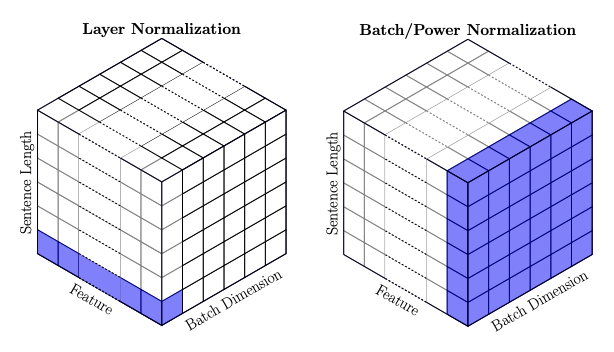

In [ ]:
# @title Simple test of normalization

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(f"{out.shape=}")
print(f"{out=}")

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(f"{mean=}")
print(f"{var=}")
normalized = (out - mean) / torch.sqrt(var)
print(f"{normalized=}")

mean_normalized = normalized.mean(dim=-1, keepdim=True)
var_normalized = normalized.var(dim=-1, keepdim=True)
print(f"{mean_normalized=}")
print(f"{var_normalized=}")

out.shape=torch.Size([2, 6])
out=tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
mean=tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
var=tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)
normalized=tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean_normalized=tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
var_normalized=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# @title Real impl

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    # x [B, N, H_DIM]
    mean = x.mean(dim=-1, keepdim=True) # [B, N, 1]
    #  in the variance calculation, we divide by the number of inputs n in the variance formula. This approach does
    # not apply Bessel’s correction, which typically uses n – 1 instead of n in the denomi-
    # nator to adjust for bias in sample variance estimation. This decision results in a so-
    # called biased estimate of the variance. For LLMs, where the embedding dimension n
    # is significantly large, the difference between using n and n – 1 is practically negligible.
    # I chose this approach to ensure compatibility with the GPT-2 model’s normalization
    # layers and because it reflects TensorFlow’s default behavior, which was used to
    # implement the original GPT-2 model. Using a similar setting ensures our method is
    # compatible with the pretrained weights we will load in chapter 6.
    var = x.var(dim=-1, keepdim=True, unbiased=False)   # [B, N, 1]
    normalized = (x - mean) / torch.sqrt(var + self.eps) # [B, N, H_DIM]
    return self.scale * normalized + self.shift

ln = LayerNorm(5)
out = ln(batch_example)
print(out)

out_mean = out.mean(dim=-1, keepdim=True)
out_var = out.var(dim=-1, keepdim=True, unbiased=False)
print(f"{out_mean=}")
print(f"{out_var=}")

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
out_mean=tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
out_var=tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


# GeLU

- Smoother than ReLU
- SwiGLU is another widely used activation

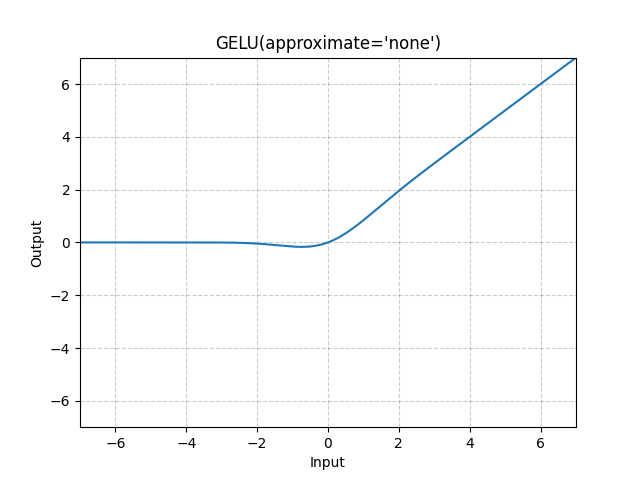

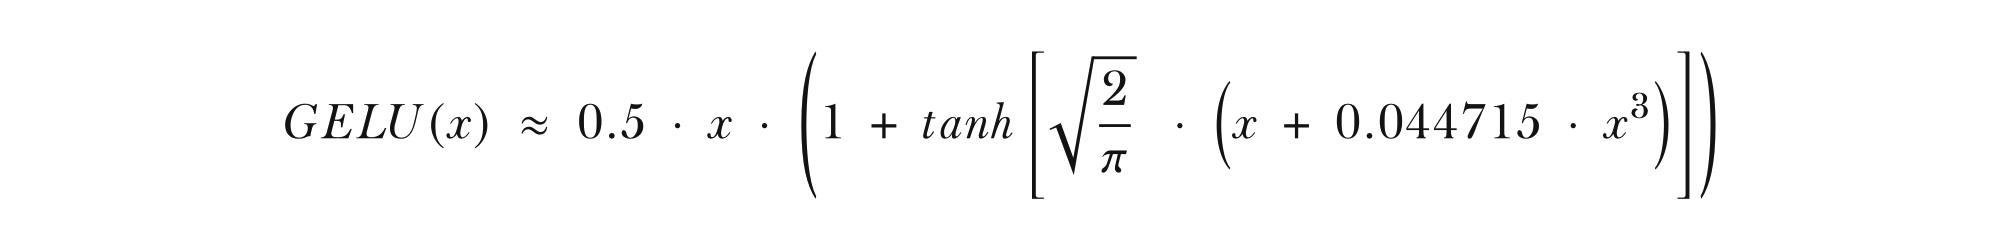

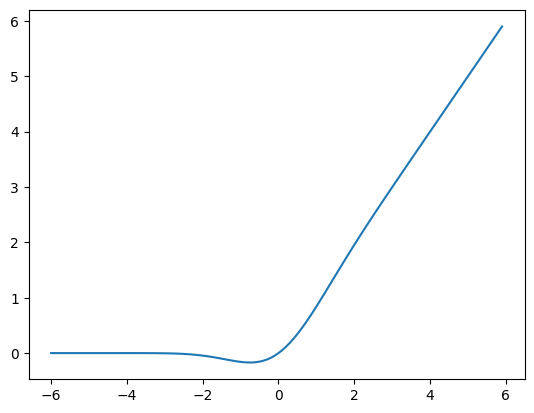

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GELU(nn.Module):
  def __init__(self):
    super().__init__()


  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

# Test
gelu = GELU()
data_example = torch.tensor(np.arange(-6, 6, 0.1))
out = gelu(data_example)

plt.plot(data_example.numpy(), out.numpy())

# FFN

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(config["emb_dim"], config["emb_dim"] * 4),
        GELU(),
        nn.Linear(config["emb_dim"] * 4, config["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

# Skip Connection

In [ ]:
# @title Test a toy skip connection

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[2], layer_sizes[3]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[3], layer_sizes[4]),
            GELU(),
        ),
        nn.Sequential(
            nn.Linear(layer_sizes[4], layer_sizes[5]),
            GELU(),
        ),
    ])

  def forward(self, x):
    for l in self.layers:
      y = l(x)
      if self.use_shortcut:
        y += x
      x = y
    return x

# Transformer block

Connect the components together

In [ ]:
# @title MHA coplied from Chap 03

class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
    super().__init__()

    assert d_out % num_heads == 0, "d_out must be divisible by num_heads!"

    self.heads = num_heads
    self.head_dim = d_out // num_heads

    self.wk = nn.Linear(d_in, d_out, bias=qkv_bias) # [E, H]
    self.wq = nn.Linear(d_in, d_out, bias=qkv_bias) # [E, H]
    self.wv = nn.Linear(d_in, d_out, bias=qkv_bias) # [E, H]
    self.droput = nn.Dropout(dropout)
    self.out_proj = nn.Linear(d_out, d_out)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    """Forward.

    Args:
      x: [B, N, E]

    Returns:
      [B, N, H]
    """
    b, n, d_in = x.shape

    k = self.wk(x) # [B, N, H]
    q = self.wq(x) # [B, N, H]
    v = self.wv(x) # [B, N, H]

    k = k.view(b, n, self.heads, self.head_dim).transpose(1, 2) # [B, HEADS, N, HEAD_DIM]
    q = q.view(b, n, self.heads, self.head_dim).transpose(1, 2) # [B, HEADS, N, HEAD_DIM]
    v = v.view(b, n, self.heads, self.head_dim).transpose(1, 2) # [B, HEADS, N, HEAD_DIM]

    attn = q @ k.transpose(-1, -2) # [B, HEADS, N, N]
    assert attn.shape == (b, self.heads, n, n)
    # print(f"Before causal: {attn=}")

    # [:n, :n] is to truncate to the length of input tokens.
    attn = attn.masked_fill(self.mask.bool()[:n, :n], -torch.inf)
    # print(f"After causal: {attn[0][0]=}")

    attn /= self.head_dim ** 0.5
    attn = nn.functional.softmax(attn, dim=-1)
    # print(f"After softmax: {attn[0][0]=}")
    attn = self.droput(attn)
    res = attn @ v # [B, HEADS, N, H]
    res = res.transpose(1, 2).contiguous().view(b, n, -1) # [B, N, H]

    res = self.out_proj(res)  # [B, N, H]

    return res

In [ ]:
# @title The Transformer block

class TransformerBlock(nn.Module):

  def __init__(self, config):
    super().__init__()

    self.norm1 = LayerNorm(config["emb_dim"])
    self.norm2 = LayerNorm(config["emb_dim"])
    self.mha = MultiHeadAttention(
        d_in=config["emb_dim"],
        d_out=config["emb_dim"],
        context_length=config['context_length'],
        num_heads=config["n_heads"],
        dropout=config["drop_rate"],
        qkv_bias=config["qkv_bias"]
    )
    self.ffn = FeedForward(config)
    self.dropout = nn.Dropout(config['drop_rate'])

  def forward(self, x):
    shortcut = x
    y = self.norm1(x)
    y = self.mha(y)
    # TODO: is this needed since the MHA already has the dropout internally.
    y = self.dropout(y)
    x = y + shortcut

    shortcut = x
    y = self.norm2(x)
    y = self.ffn(y)
    y = self.dropout(y)
    y = y + shortcut

    return y


# The GPT Model

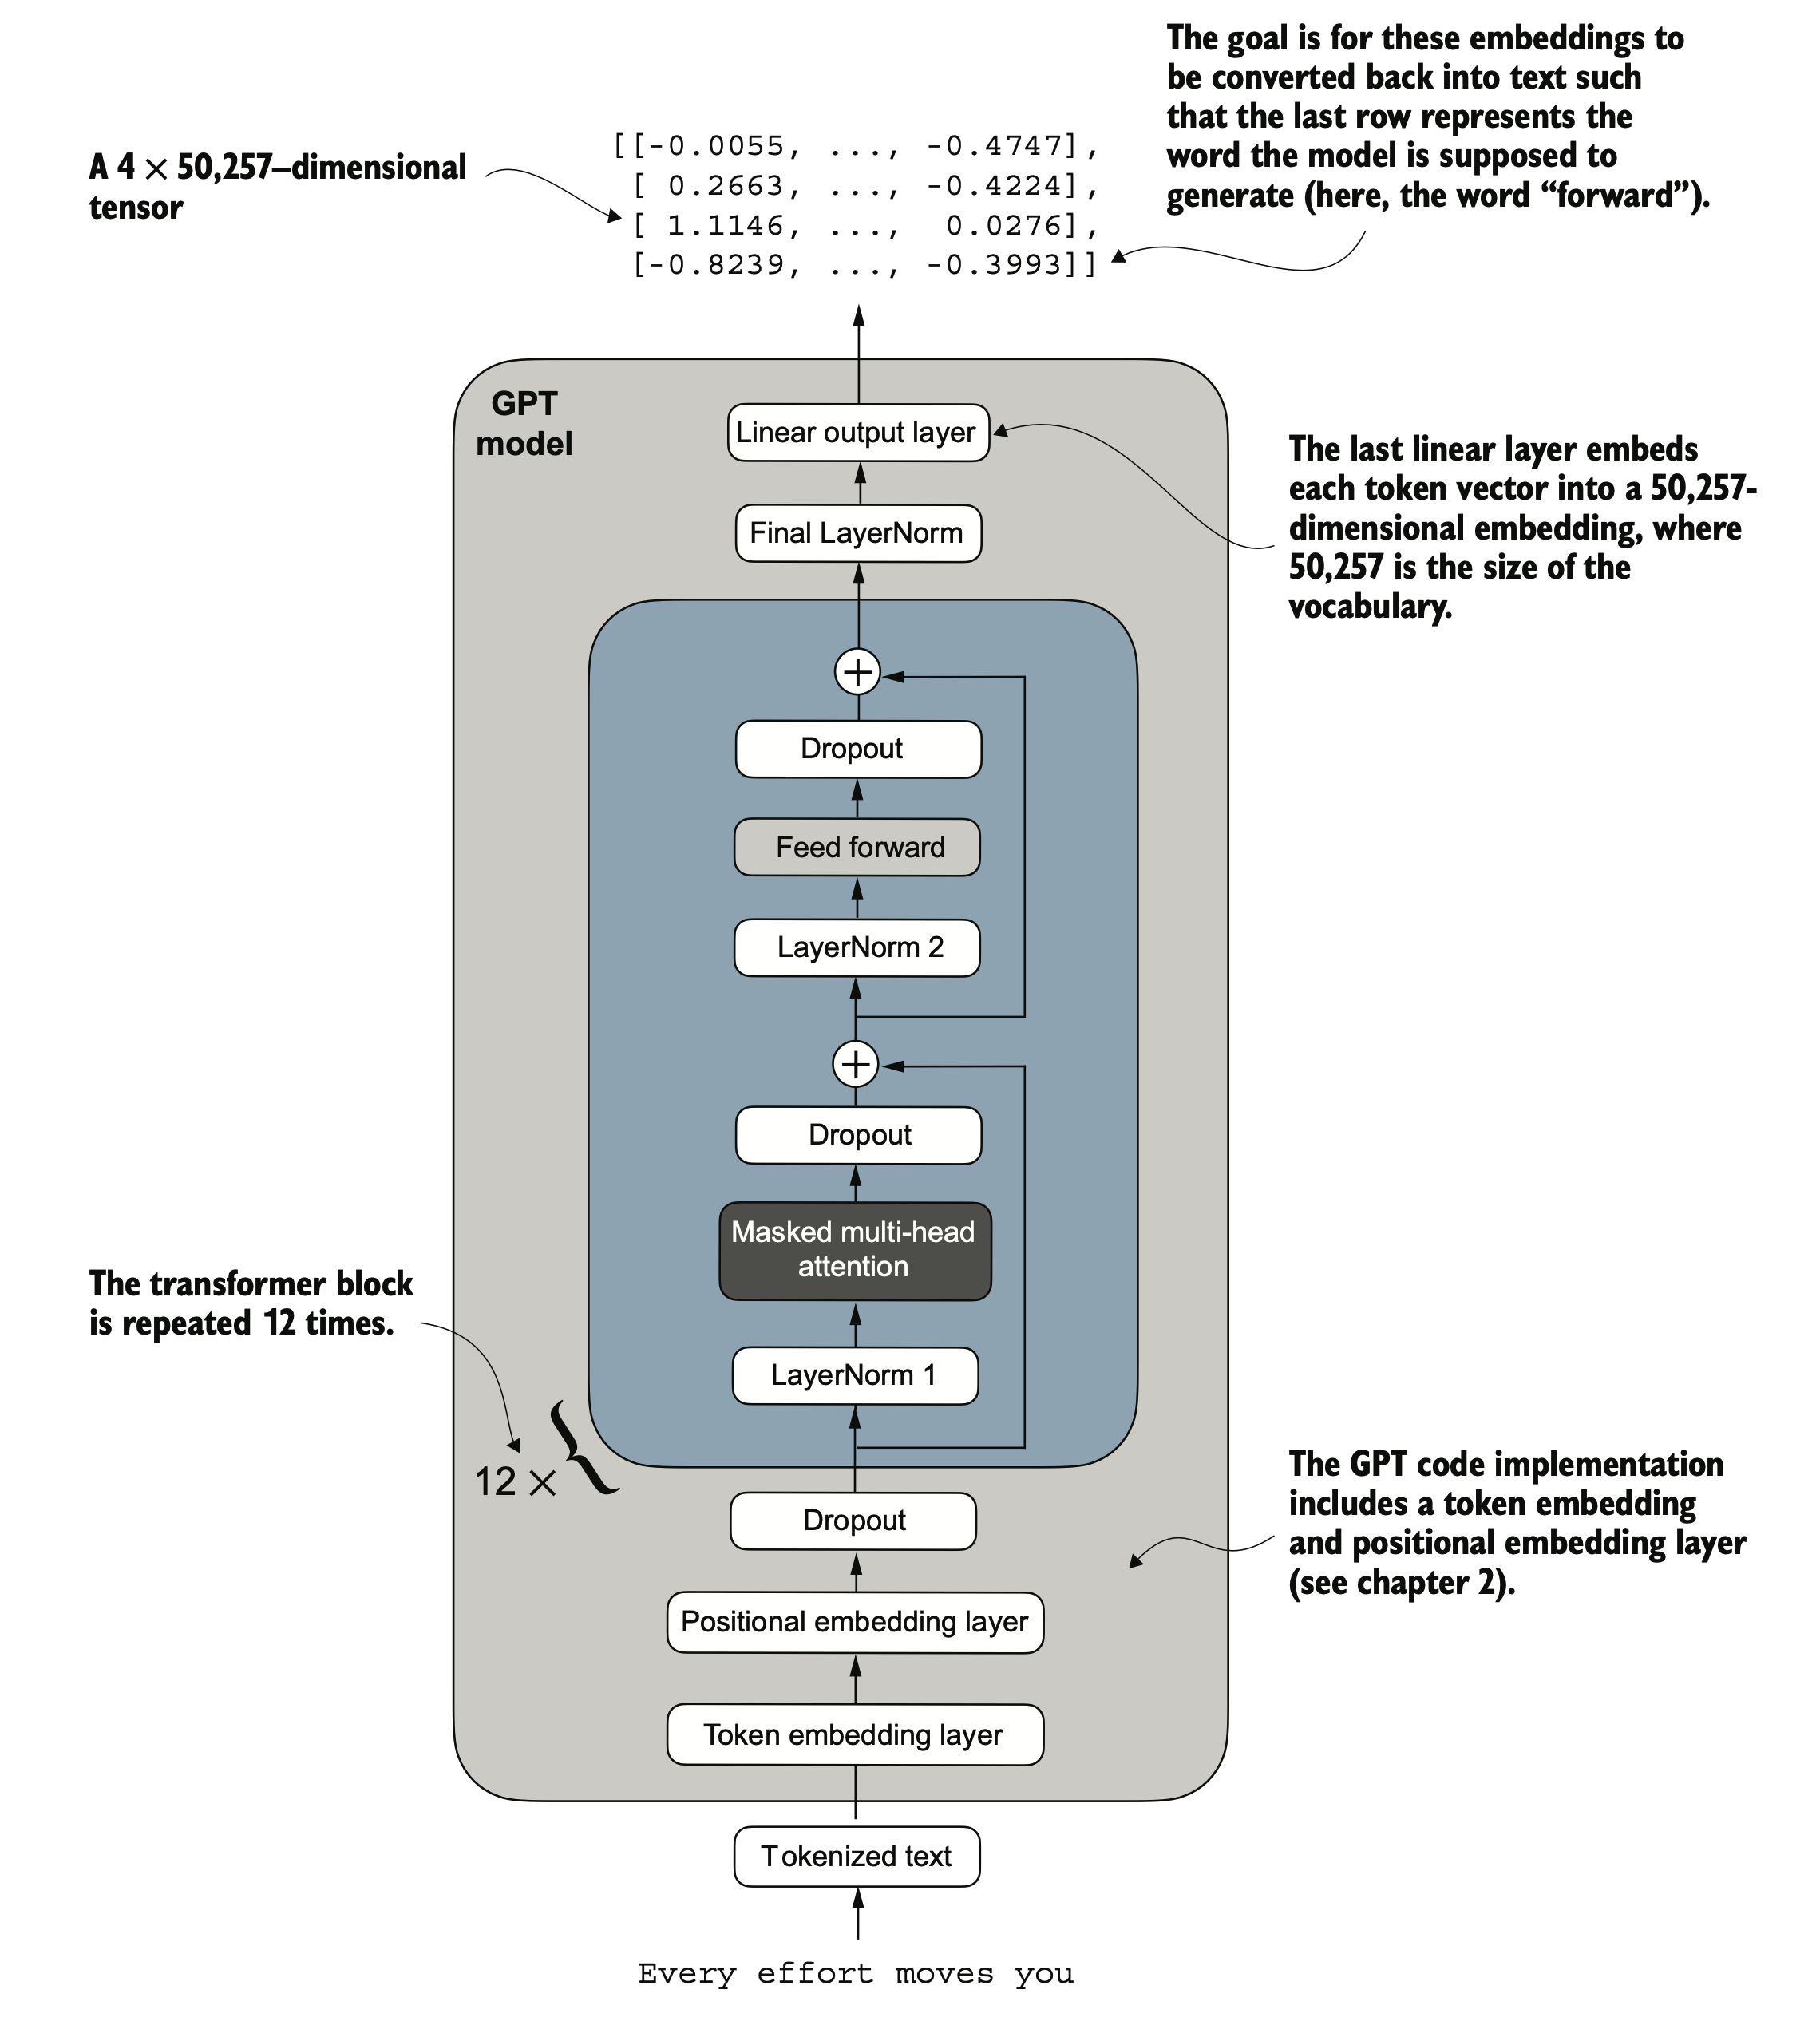

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.tok_emb = nn.Embedding(config["vocab_size"], config["emb_dim"])
    self.pos_emb = nn.Embedding(config["context_length"], config["emb_dim"])
    self.drop = nn.Dropout(config["drop_rate"])
    self.trf_blocks = nn.Sequential(*[TransformerBlock(config) for _ in range(config["n_layers"])])
    self.final_norm = LayerNorm(config["emb_dim"])
    self.out_head = nn.Linear(config["emb_dim"], config["vocab_size"], bias=False)

  def forward(self, x):
    bs, seq_len = x.shape
    tok_emb = self.tok_emb(x)
    pos_emb = self.pos_emb(torch.arange(seq_len, device=x.device))
    x = tok_emb + pos_emb
    x = self.drop(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


## Weight Typing

We can see above that the model has 163M params; but GPT-2 has 124M params. Why is there difference?

This is because GPT-2 uses the same weights for the 1) input embedding, and 2) output projection. This is called **Weight Typing**.

We will enable this later. Based on the author's experience, weight typing has **negative impact** on model performance.

# Predict Text

In [ ]:
# @title A better generation fn

def generate_text_simple(model, idx, max_new_tokens, context_size):
  """Greedy decoding."""
  for i in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)    # [B, N, D_IN]
    logits = logits[:, -1, :] # [B, D_IN]
    probs = nn.functional.softmax(logits, -1)  # [B, D_IN]
    idx_next = probs.argmax(-1) # [B]

    idx = torch.cat([idx, idx_next.view(-1, 1)], -1)

  return idx

# This is the start of real Chapter 5
- The previous sections are libs copied from Chapter 4

# Utility for token & text conversions

In [ ]:
def text_to_token_ids(text: str, tokenizer) -> torch.Tensor:
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # [1, N]
  return encoded_tensor

def token_ids_to_text(token_ids: torch.Tensor, tokenizer) -> str:
  """Convert token ids to text.

  It assumes the token_ids has B dim == 1.
  """
  return tokenizer.decode(token_ids.squeeze().numpy())

text = "test test testtesttest"
token_ids = text_to_token_ids(text, tokenizer)
converted_back_text = token_ids_to_text(token_ids, tokenizer)
assert converted_back_text == text

# Loss metrics

## Manually calculate NLL

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])     # "I really like"]
targets = torch.tensor([[3626, 6100, 345], # [" effort moves you",
                        [1107, 588, 11311]])     # " really like chocolate"]

print(f"{inputs.shape=}")
assert inputs.shape == targets.shape

inputs.shape=torch.Size([2, 3])


# Decoding Strategies

## Temperature Scaling

1. It applies a “temperature” on each token’s probability. This is done by a) dividing the temperature on each token’s logits, 2) then using softmax to compute the probability.

  - When T==1, no scaling - equivalent as directly doing step 2.
  - When T > 1, the step 2 distribution is more uniform.
  - When T < 1, the step 2 distribution is more biased on high probability.

2. This is similar to the ATTN block dividing the attention softmax by sqrt(D_K)
Then sample the token based on the corresponding probability (torch.multimonial())



temperature=0.1, counts=[('forward', 100)]
temperature=0.5, counts=[('forward', 63), ('toward', 36), ('closer', 1)]
temperature=1, counts=[('forward', 58), ('toward', 39), ('closer', 3)]
temperature=5, counts=[('toward', 22), ('forward', 22), ('closer', 20), ('you', 10), ('inches', 9), ('moves', 7), ('every', 5), ('pizza', 3), ('effort', 2)]
temperature=10, counts=[('forward', 19), ('closer', 18), ('toward', 14), ('effort', 11), ('inches', 10), ('every', 9), ('you', 8), ('pizza', 7), ('moves', 4)]
temperature=20, counts=[('toward', 17), ('effort', 16), ('closer', 13), ('forward', 12), ('inches', 11), ('pizza', 11), ('every', 11), ('you', 6), ('moves', 3)]


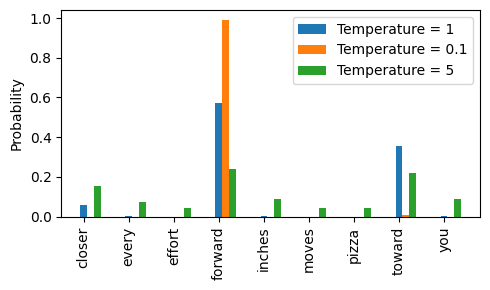

In [ ]:
# @title simple test

import copy

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
assert len(next_token_logits) == len(vocab)

def softmax_with_temperature(logits, temperature):
  logits = copy.deepcopy(logits)
  if temperature:
    assert temperature > 0, f"{temperature} MUST > 0"
    logits /= temperature
  return nn.functional.softmax(logits, dim=-1)

def sample_n_times(next_token_logits, n, temperature):
  counts = {}
  for _ in range(n):
    probas = softmax_with_temperature(next_token_logits, temperature)
    next_token_id = probas.multinomial(num_samples=1).item()
    next_text = inverse_vocab[next_token_id]
    if next_text in counts:
      counts[next_text] += 1
    else:
      counts[next_text] = 1
  return sorted([(k, v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)

# When temp increases, it expects a more uniformed distribution.
for temperature in (0.1, 0.5, 1, 5, 10, 20):
  counts = sample_n_times(next_token_logits, 100, temperature)
  print(f"{temperature=}, {counts=}")

# Plot distribution @ different temp
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

## Top-K

When sampling, only sample among the top-k results. This helps to **avoid the very non-sense tokens** to be sampled.

It can be used together with the **temperature scaling**.

In [ ]:
# @title simple test

def sample_n_times(next_token_logits, n, temperature, k):
  counts = {}
  for _ in range(n):
    top_logits, top_pos = torch.topk(next_token_logits, k)  # [B, K]
    top_k_logits = torch.where(
        condition=next_token_logits < top_logits[-1],
        input=torch.tensor(float('-inf')),
        other=next_token_logits
    )

    probas = softmax_with_temperature(next_token_logits, temperature)
    next_token_id = probas.multinomial(num_samples=1).item()
    next_text = inverse_vocab[next_token_id]
    if next_text in counts:
      counts[next_text] += 1
    else:
      counts[next_text] = 1
  return sorted([(k, v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)

# When temp increases, it expects a more uniformed distribution.
for temperature in (0.1, 0.5, 1, 5, 10, 20):
  counts = sample_n_times(next_token_logits, 100, temperature, k=3)
  print(f"{temperature=}, {counts=}")

temperature=0.1, counts=[('forward', 100)]
temperature=0.5, counts=[('forward', 74), ('toward', 26)]
temperature=1, counts=[('forward', 62), ('toward', 27), ('closer', 11)]
temperature=5, counts=[('toward', 27), ('forward', 16), ('closer', 15), ('you', 14), ('every', 9), ('inches', 9), ('moves', 5), ('pizza', 3), ('effort', 2)]
temperature=10, counts=[('you', 19), ('toward', 18), ('inches', 13), ('closer', 11), ('every', 10), ('pizza', 10), ('forward', 8), ('moves', 6), ('effort', 5)]
temperature=20, counts=[('toward', 17), ('closer', 15), ('forward', 15), ('you', 11), ('moves', 11), ('every', 10), ('inches', 8), ('effort', 7), ('pizza', 6)]


## Combine temperature scaling and top-k

In [ ]:
def generate(
    model, idx, max_new_tokens, context_size,
    temperature: float, top_k=1, eos_id=None) -> torch.Tensor:
  """Combined temperature scaling + top-k decoding."""
  model.eval()
  for i in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)    # [B, N, D_IN]
    logits = logits[:, -1, :] # [B, D_IN]

    # Top-k
    top_logits, top_pos = torch.topk(logits, top_k, dim=-1)  # [B, K]
    threshold = top_logits[:, -1].unsqueeze(dim=1)          # [B, 1]
    top_k_logits = torch.where(
        condition=(logits - threshold < 0),
        input=torch.tensor(float('-inf')),
        other=logits
    )

    # Temperature scaling
    probs = softmax_with_temperature(top_k_logits, temperature) # [B, D_IN]

    idx_next = probs.multinomial(num_samples=1) # [B, 1]

    idx = torch.cat([idx, idx_next.view(-1, 1)], -1)  # [B, D_IN + max_new_tokens]
    if eos_id and idx_next == eos_id:
      break

  model.train()
  return idx


# Load GPT-2 Model

The weights are originally saved in Tensorflow.

In [ ]:
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
# @title Download weights

import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7b6f99917dd0>)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 144kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 582kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 148kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [02:25<00:00, 3.42MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.08MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 339kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 328kiB/s]


In [ ]:
# @title Inspect the downloaded weights

import numpy as np

print(f"LLM architecture settings: {settings}")

print(f"Parameter dict (containing the actual weight tensors) keys: {params.keys()}")

for k, v in params.items():
  # print(f"{type(v)=}")
  if isinstance(v, np.ndarray):
    print(f"{k}: {v.shape}")
  else:
    print(f"{k}: {len(v)}")
    # print(f"{v=}")

LLM architecture settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dict (containing the actual weight tensors) keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
blocks: 12
b: (768,)
g: (768,)
wpe: (1024, 768)
wte: (50257, 768)


In [ ]:
# @title Update the config with GPT-2 config

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

# We use 256 for simplicy; GPT-2 use 1024 context length.
NEW_CONFIG.update({"context_length": 1024})

# The bias in ATTN qkv linear layer. These are not used in recent models since they don't improve the modeling performance.
NEW_CONFIG.update({"qkv_bias": True})

In [ ]:
# @title Initialize the model

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        

In [ ]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

In [ ]:
def load_weights_into_gpt(gpt, params):
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

  for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].mha.wq.weight = assign(
        gpt.trf_blocks[b].mha.wq.weight, q_w.T)
    gpt.trf_blocks[b].mha.wk.weight = assign(
        gpt.trf_blocks[b].mha.wk.weight, k_w.T)
    gpt.trf_blocks[b].mha.wv.weight = assign(
        gpt.trf_blocks[b].mha.wv.weight, v_w.T)
    q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].mha.wq.bias = assign(
        gpt.trf_blocks[b].mha.wq.bias, q_b)
    gpt.trf_blocks[b].mha.wk.bias = assign(
        gpt.trf_blocks[b].mha.wk.bias, k_b)
    gpt.trf_blocks[b].mha.wv.bias = assign(
        gpt.trf_blocks[b].mha.wv.bias, v_b)

    gpt.trf_blocks[b].mha.out_proj.weight = assign(
        gpt.trf_blocks[b].mha.out_proj.weight,
        params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].mha.out_proj.bias = assign(
        gpt.trf_blocks[b].mha.out_proj.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])

    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
        gpt.trf_blocks[b].ffn.layers[0].weight,
        params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
        gpt.trf_blocks[b].ffn.layers[0].bias,
        params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
        gpt.trf_blocks[b].ffn.layers[2].weight,
        params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
        gpt.trf_blocks[b].ffn.layers[2].bias,
        params["blocks"][b]["mlp"]["c_proj"]["b"])

    gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale,
        params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift,
        params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale,
        params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift,
        params["blocks"][b]["ln_2"]["b"])

  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (droput): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (mha): MultiHeadAttention(
        

In [ ]:
# Test
torch.manual_seed(123)

idx = text_to_token_ids("Is Texas in USA?", tokenizer).to(device)
print(f"{idx.shape=}")
for _ in range(10):
  print("=" * 80)

  out = generate(
      gpt,
      idx,
      max_new_tokens=25,
      context_size=NEW_CONFIG["context_length"],
      temperature=1.5,
      top_k=50)

  print(token_ids_to_text(out[0, :].to('cpu'), tokenizer))


idx.shape=torch.Size([1, 5])
Is Texas in USA?

A lot can happen because of the nature of this world of yours. You have a very small number (no one
Is Texas in USA?

What do u know on why Texas has so many athletes like DeLaHoya, Taveras is only one
Is Texas in USA?

It's pretty good news. Yes it's been bad there, but all I ask, is for Dallas Mavericks guard
Is Texas in USA? Click here If you have questions please refer to the article below from The Texas Observer. The Texas Sun also notes that "as
Is Texas in USA? Or is America an independent country, and when you live your nation becomes yours, right? Is it good we have such laws
Is Texas in USA? (The above image shows a map where the number of people living in Mexico)

Click here for more information on how
Is Texas in USA? The USA is still not fully on par with New England on an annual basis and is also the most isolated country in Europe [
Is Texas in USA? (Partner for this issue, I'm in Iowa.) In my quest to improve America by hel

# Test whether the Pre-trained model can classify

In [ ]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

torch.manual_seed(123)

idx = text_to_token_ids(text_2, tokenizer).to(device)
print(f"{idx.shape=}")
for _ in range(10):
  print("=" * 80)

  out = generate_text_simple(
      gpt,
      idx,
      max_new_tokens=23,
      context_size=NEW_CONFIG["context_length"])

  print(token_ids_to_text(out[0, :].to('cpu'), tokenizer))

idx.shape=torch.Size([1, 38])
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

Answer with 'yes' or 'You are a winner' or 'You are a winner' or '
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The text 'spam' is a spam message sent to a recipient's computer. It is a spam
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'


'You are a winner you have been specially selected to receive $1000 cash or $2000 award.'
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

Answer with 'yes' or 'no': 'You have been selected to receive $1000 cash or a
Is the following text 'spam'? Answer with 'yes' or 'no'

# Prepare for classification task

##  Add a classification head

1. We replace the last layer to 2 output dims for the binary classification classes.

2. We freeze most of the previous layers for training. We leave the new last layer, and 2 other latest layers (it is found that have slightly more layers unfronzen for training helps the quality), for training.

3. We use the logits from the last token output for classification, because only this token can see all the previous context (causal).

In [ ]:
def change_to_classification_head(model):
  for param in gpt.parameters():
    param.requires_grad = False

  torch.manual_seed(123)
  num_classes = 2
  gpt.out_head = nn.Linear(NEW_CONFIG["emb_dim"], num_classes)

  for param in gpt.final_norm.parameters():
    param.requires_grad = True

  for param in gpt.trf_blocks[-1].parameters():
    param.requires_grad = True

change_to_classification_head(gpt)
print("Unfrozen parameters:")
for name, param in gpt.named_parameters():
  if param.requires_grad:
    print(name)

Unfrozen parameters:
trf_blocks.11.norm1.scale
trf_blocks.11.norm1.shift
trf_blocks.11.norm2.scale
trf_blocks.11.norm2.shift
trf_blocks.11.mha.wk.weight
trf_blocks.11.mha.wq.weight
trf_blocks.11.mha.wv.weight
trf_blocks.11.mha.out_proj.weight
trf_blocks.11.mha.out_proj.bias
trf_blocks.11.ffn.layers.0.weight
trf_blocks.11.ffn.layers.0.bias
trf_blocks.11.ffn.layers.2.weight
trf_blocks.11.ffn.layers.2.bias
final_norm.scale
final_norm.shift
out_head.weight
out_head.bias


In [ ]:
# Test
inputs = tokenizer.encode("Do you have time")
inputs = torch.Tensor(inputs).int().unsqueeze(0).to(device)
print(f"{inputs=}")
gpt.to(device)
logits = gpt(inputs)    # [B, N, N_CLASS]

print(f"{logits.shape=}")
probas = torch.softmax(logits[:, -1, :], dim=-1)
label = torch.argmax(probas, dim=-1)
print(f"{probas=}")
print(f"Class label: {label.item()}")

inputs=tensor([[5211,  345,  423,  640]], device='cuda:0', dtype=torch.int32)
logits.shape=torch.Size([1, 4, 2])
probas=tensor([[7.4654e-05, 9.9993e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Class label: 1


## Classification accuracy

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None) -> float:
  """Calculate the accuracy for the given loader."""
  model.eval()
  correct_predictions, num_examples = 0, 0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input, label) in enumerate(data_loader):
    if i >= num_batches:
      break

    num_examples += input.shape[0]

    input = input.to(device)
    with torch.no_grad():
      logits = model(input)   # [B, N, N_CLASS]
    probas = torch.softmax(logits[:, -1, :], dim=-1)  # [B, N_CLASS]
    pred = torch.argmax(probas, dim=-1)               # [B]
    eq = torch.eq(pred, label.to(device))
    correct_predictions += torch.sum(eq).item()

  model.train()

  return 1.0 * correct_predictions / num_examples

torch.manual_seed(123)

train_acc = calc_accuracy_loader(train_loader, gpt, device)
print(f"Train data {train_acc=:.2f}")

val_acc = calc_accuracy_loader(val_loader, gpt, device)
print(f"Train data {val_acc=:.2f}")

test_acc = calc_accuracy_loader(test_loader, gpt, device)
print(f"Train data {test_acc=:.2f}")

Train data train_acc=0.50
Train data val_acc=0.53
Train data test_acc=0.50


## Classification Loss

Cross-entropy

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device) -> torch.Tensor:
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)   # [B, N, N_CLASS]
  loss = nn.functional.cross_entropy(logits[:, -1, :], target_batch)
  return loss

torch.manual_seed(123)

for input_batch, target_batch in train_loader:
  loss = calc_loss_batch(input_batch, target_batch, gpt, device)
  print(f"{loss.item()=:.2f}")
  break

def calc_loss_loader(data_loader, model, device, num_batches=None) -> float:
  model.eval()
  total_loss = 0.0

  if num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))

  for i, (input, label) in enumerate(data_loader):
    if i >= num_batches:
      break

    loss = calc_loss_batch(input, label, model, device)
    total_loss += loss.item()

  model.train()

  return total_loss / num_batches

train_loss = calc_loss_loader(train_loader, gpt, device)
print(f"Train data {train_loss=:.2f}")

val_loss = calc_loss_loader(val_loader, gpt, device)
print(f"Train data {val_loss=:.2f}")

test_loss = calc_loss_loader(test_loader, gpt, device)
print(f"Train data {test_loss=:.2f}")

loss.item()=3.29
Train data train_loss=2.61
Train data val_loss=2.42
Train data test_loss=2.55


# Train

In [ ]:
def evaluate_model(
    model, train_loader, val_loader, device, n_eval_batches: int
  ) -> tuple[torch.Tensor, torch.Tensor]:
  """Evaluate the model.

  Args:
    model: The model to evaluate.
    train_loader: The training data loader.
    val_loader: The validation data loader.
    device: The device to use for training.
    n_eval_batches: The number of batches to evaluate.

  Returns:
    train_loss: The training loss.
    val_loss: The validation loss.
  """
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=n_eval_batches)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=n_eval_batches)
  model.train()

  return train_loss, val_loss


def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter):
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []

  examples_seen = 0
  global_step = -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()

      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, n_eval_batches=eval_iter)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} (step {global_step}): train loss {train_loss:.3f}, val loss {val_loss:.3f}")

    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

  return train_losses, val_losses, train_accs, val_accs, examples_seen

torch.manual_seed(123)

gpt = GPTModel(NEW_CONFIG)
load_weights_into_gpt(gpt, params)
change_to_classification_head(gpt)
gpt.to(device)

num_epochs=10
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    gpt, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)


Epoch 1 (step 0): train loss 2.175, val loss 2.520
Epoch 1 (step 50): train loss 0.734, val loss 0.780
Epoch 1 (step 100): train loss 0.622, val loss 0.708
Training accuracy: 45.00% | Validation accuracy: 55.00%
Epoch 2 (step 150): train loss 0.631, val loss 0.635
Epoch 2 (step 200): train loss 0.667, val loss 0.606
Epoch 2 (step 250): train loss 0.639, val loss 0.586
Training accuracy: 82.50% | Validation accuracy: 85.00%
Epoch 3 (step 300): train loss 0.763, val loss 0.491
Epoch 3 (step 350): train loss 0.493, val loss 0.449
Training accuracy: 62.50% | Validation accuracy: 75.00%
Epoch 4 (step 400): train loss 0.484, val loss 0.515
Epoch 4 (step 450): train loss 0.639, val loss 0.585
Epoch 4 (step 500): train loss 0.613, val loss 0.525
Training accuracy: 75.00% | Validation accuracy: 65.00%
Epoch 5 (step 550): train loss 0.621, val loss 0.519
Epoch 5 (step 600): train loss 0.367, val loss 0.485
Training accuracy: 87.50% | Validation accuracy: 90.00%
Epoch 6 (step 650): train loss 0.3

In [ ]:
num_epochs

5

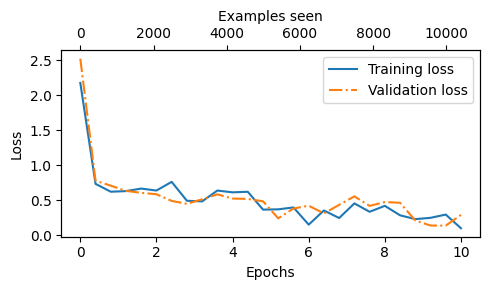

In [ ]:
# @title Plot Loss

import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(
      epochs_seen, val_values, linestyle="-.",
      label=f"Validation {label}"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")

  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

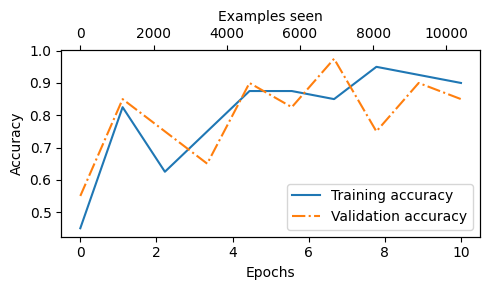

In [ ]:
# @title Plot accuracy

epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
val_accuracy = calc_accuracy_loader(val_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 91.44%
Validation accuracy: 90.60%
Test accuracy: 92.33%
